# CS203 Lab 6

## Team Number: 33
## Team Members

### Member 1
- Name: Vivek Raj
- Roll No: 23110362
- Github: VivekRaj2708

### Member 2
- Name: Sharvari Mirge
- Roll No: 23110298
- Github: msharvari31


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import numpy as np

In [ ]:
data = load_iris()
X = data['data']
Y = data['target']
labels = []

for x in range(len(Y)):
    if Y[x] == 0:
        labels.append('setosa')
    elif Y[x] == 1:
        labels.append('versicolor')
    else:
        labels.append('virginica')

In [ ]:
X_normed = X / X.max(axis=0)

In [ ]:
X_train, X_testing, y_train, y_testing = train_test_split(X_normed, Y, test_size=0.3, random_state=20)
X_validation, X_test, y_validation, y_test = train_test_split(X_testing, y_testing, test_size=0.33, random_state=20)
print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(105, 4) (30, 4) (15, 4) (105,) (30,) (15,)


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch import nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# model = nn.Sequential(
#     nn.Linear(4, 16),
#     nn.ReLU(),
#     nn.Linear(16, 3),
#     nn.Softmax()
# )

class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(4, 16)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(16, 3)
        self.softmax = nn.Softmax()

    def forward(self, x):
      x = self.layer1(x)
      x = self.activation(x)
      x = self.layer2(x)
      x = self.softmax(x)
      return x

model = MLP()
model.to(device)
optimiser = AdamW(model.parameters(), lr=0.001)
criteria = CrossEntropyLoss()

In [ ]:
from torch import tensor
from torch.utils.data import DataLoader, TensorDataset


X_train_model = tensor(X_train, dtype=torch.float32)
y_train_model = tensor(y_train)

train_dataset = TensorDataset(X_train_model, y_train_model)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(tensor(X_validation, dtype=torch.float32), tensor(y_validation))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(tensor(X_test, dtype=torch.float32), tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
epochs = 50
model.train()

training_loss = []
valid_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    model.train()
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criteria(outputs, Y_batch)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)

    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.item()
      avg_val_loss = val_loss / len(val_loader)
      valid_loss.append(avg_val_loss)

    if (epoch+1) % 10 == 0:
      print(f'Epoch {epoch+1}/{epochs}, Test Loss: {avg_loss:.4f}, , Val Loss: {avg_val_loss:.4f}')


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 10/50, Test Loss: 1.0825, , Val Loss: 1.0859
Epoch 20/50, Test Loss: 1.0666, , Val Loss: 1.0773
Epoch 30/50, Test Loss: 1.0457, , Val Loss: 1.0661
Epoch 40/50, Test Loss: 1.0166, , Val Loss: 1.0528
Epoch 50/50, Test Loss: 0.9763, , Val Loss: 1.0336


In [ ]:
model.eval()

pred = []
label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        label.append(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Update the test accuracy
        _, preds = torch.max(outputs, 1)
        pred.append(preds.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import numpy as np

pred = np.array(pred).flatten()
label = np.array(label).flatten()
accuracy = accuracy_score(pred, label)
recall = recall_score(pred, label, average="weighted")
precision = precision_score(pred, label, average="weighted")
f1 = f1_score(pred, label, average="weighted")

print("Acc: ", accuracy, "\nRecall:",  recall, "\nPrescision:", precision, "\nF1:", f1)

Acc:  0.6666666666666666 
Recall: 0.6666666666666666 
Prescision: 1.0 
F1: 0.7692307692307693


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(50.722222222222214, 0.5, 'Predicted')

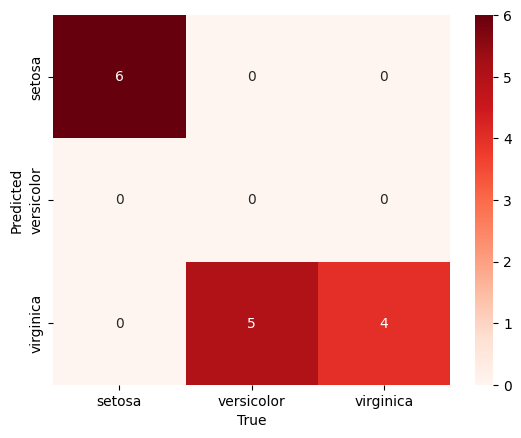

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(pred, label),
                  index = data['target_names'],
                  columns = data['target_names'])

sn.heatmap(df_cm, annot=True, cmap="Reds")
plt.xlabel("True")
plt.ylabel("Predicted")

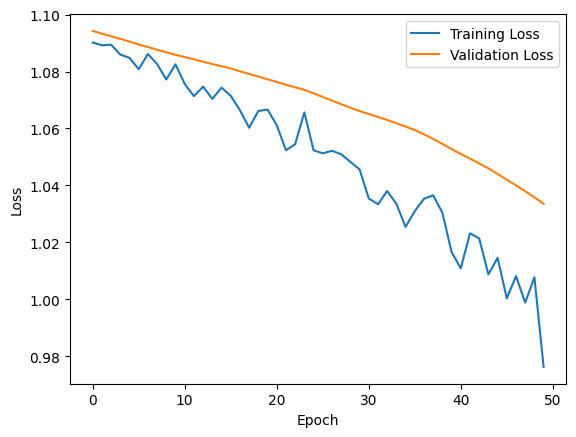

In [ ]:
plt.plot(training_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23110362 (23110362-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Log the following details:
1. Model architecture: Number of layers, neurons, activation functions.
2. Hyperparameters: Learning rate, batch size, number of epochs.
3. Training and validation loss per epoch.
4. Final evaluation metrics.
5. Confusion matrix and loss curve visualizations.

In [ ]:
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="STT-For-AI-Lab6",
    name="Run 24022025-4",
    # track hyperparameters and run metadata
    config={
      "architecture": "MLP",
      "Layers": {
          "Input": 4,
          "Hidden": 16,
          "Output": 3
      },
      "Activation": ["ReLU", "Softmax"],
      "Hyperparameter": {
              "batch_size": 32,
                "epochs": 50,
              "learning_rate": 0.001
      },
      "dataset": "IRIS",
    }
)

wandb: Currently logged in as: 23110362 (23110362-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
epochs = 50
model.train()

training_loss = []
valid_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    for X_batch, Y_batch in train_loader:
        model.train()
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criteria(outputs, Y_batch)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)

    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.item()
      avg_val_loss = val_loss / len(val_loader)
      valid_loss.append(avg_val_loss)

      wandb.log({"Training Loss": avg_loss, "Validation Loss": avg_val_loss})

      print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, , Val Loss: {avg_val_loss:.4f}')

model.eval()

pred = []
label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        label.append(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Update the test accuracy
        _, preds = torch.max(outputs, 1)
        pred.append(preds.cpu().numpy())

pred = np.array(pred).flatten()
label = np.array(label).flatten()
accuracy = accuracy_score(pred, label)
recall = recall_score(pred, label, average="weighted")
Prescison = precision_score(pred, label, average="weighted")
f1 = f1_score(pred, label, average="weighted")

print("Acc: ", accuracy, "\nRecall:",  recall, "\nPrescision:", precision, "\nF1:", f1)

wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None,
                                        preds=pred, y_true=label,
                                        class_names=data['target_names']),
               "loss_curve": wandb.plot.line_series(
                    xs=list(range(1, epochs+1)),
                    ys=[training_loss, valid_loss],
                    keys=["Train Loss", "Validation Loss"],
                    title="Loss Curve",
                    xname="Epochs"
                ),
               "Final Accuracy": accuracy,
               "Final Prescison": Prescison,
               "Final Recall" : recall,
               "Final F1": f1} )

wandb.finish()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/50, Train Loss: 0.7425, , Val Loss: 0.7946
Epoch 2/50, Train Loss: 0.7336, , Val Loss: 0.7936
Epoch 3/50, Train Loss: 0.7464, , Val Loss: 0.7926
Epoch 4/50, Train Loss: 0.7492, , Val Loss: 0.7912
Epoch 5/50, Train Loss: 0.7431, , Val Loss: 0.7897
Epoch 6/50, Train Loss: 0.7430, , Val Loss: 0.7880
Epoch 7/50, Train Loss: 0.7349, , Val Loss: 0.7865
Epoch 8/50, Train Loss: 0.7289, , Val Loss: 0.7851
Epoch 9/50, Train Loss: 0.7314, , Val Loss: 0.7839
Epoch 10/50, Train Loss: 0.7493, , Val Loss: 0.7828
Epoch 11/50, Train Loss: 0.7381, , Val Loss: 0.7815
Epoch 12/50, Train Loss: 0.7285, , Val Loss: 0.7803
Epoch 13/50, Train Loss: 0.7244, , Val Loss: 0.7791
Epoch 14/50, Train Loss: 0.7242, , Val Loss: 0.7782
Epoch 15/50, Train Loss: 0.7345, , Val Loss: 0.7773
Epoch 16/50, Train Loss: 0.7425, , Val Loss: 0.7761
Epoch 17/50, Train Loss: 0.7183, , Val Loss: 0.7748
Epoch 18/50, Train Loss: 0.7168, , Val Loss: 0.7737
Epoch 19/50, Train Loss: 0.7324, , Val Loss: 0.7727
Epoch 20/50, Train Lo

Final Accuracy,▁
Final F1,▁
Final Prescison,▁
Final Recall,▁
Training Loss,▇▆██▇▅▆█▇▅▅▆▇▄▄▆▄▄▇▄▃▅▄▅▃▄▃▄▄▄▃▄▂▂▃▂▁▄▂▁
Validation Loss,████▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Final Accuracy,0.93333
Final F1,0.93333
Final Prescison,0.94667
Final Recall,0.93333
Training Loss,0.69629


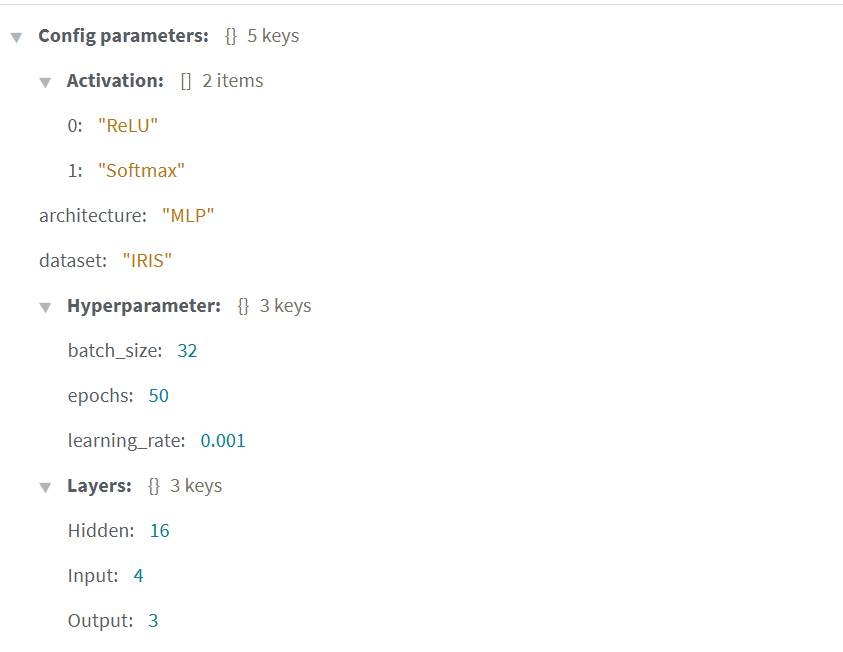

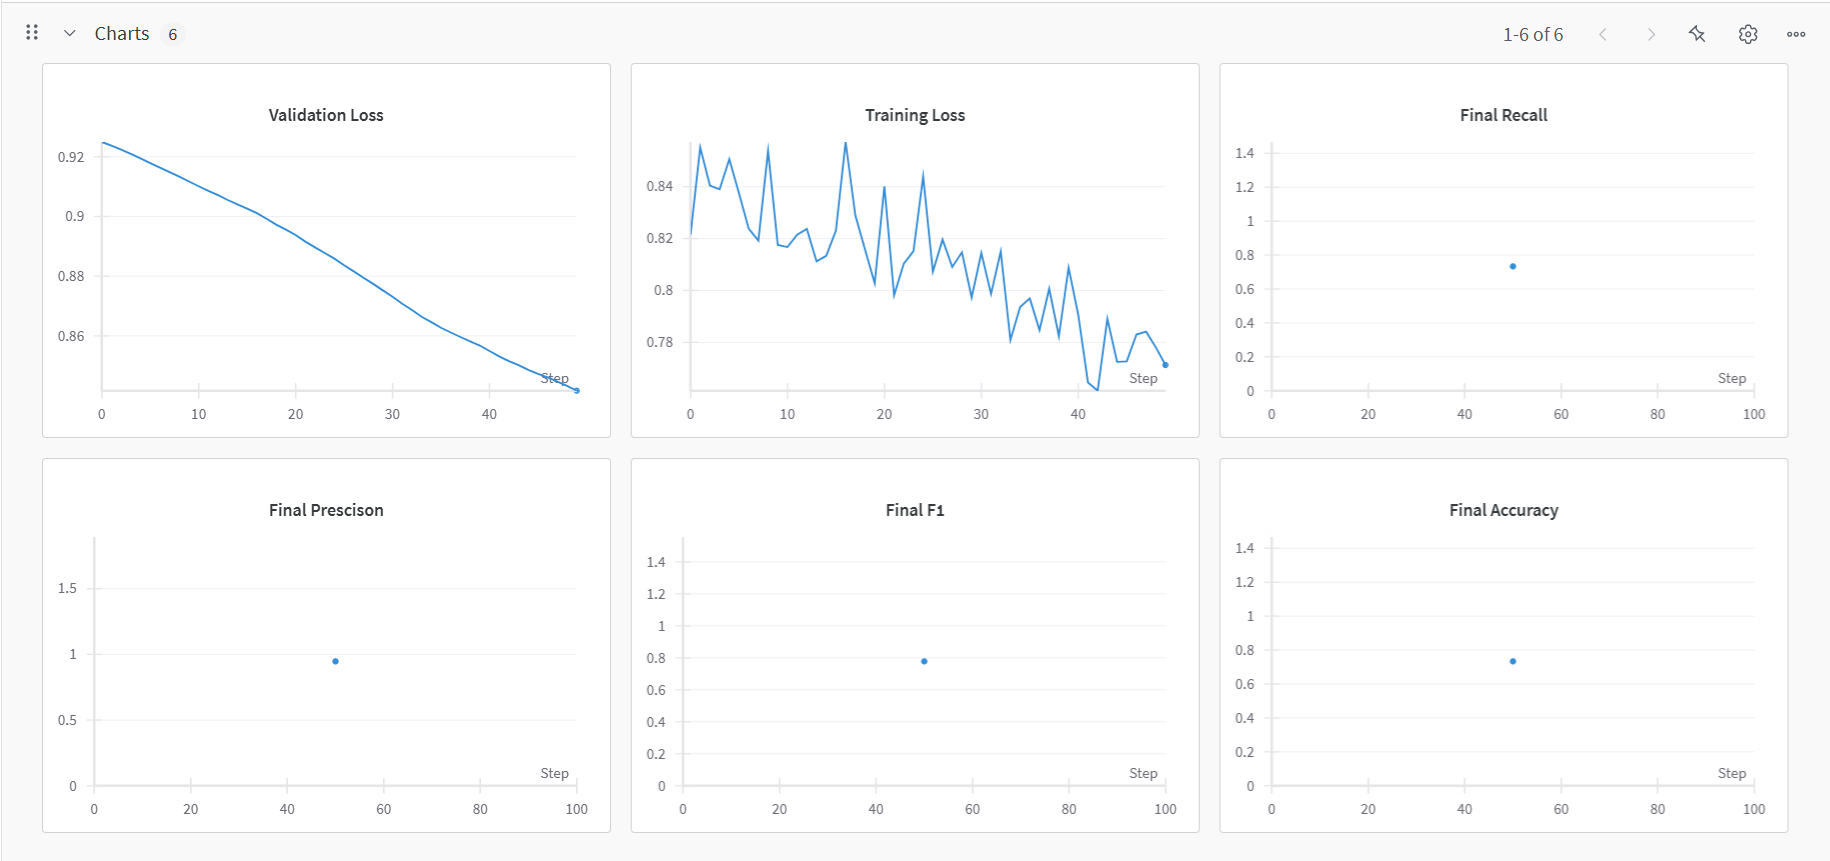

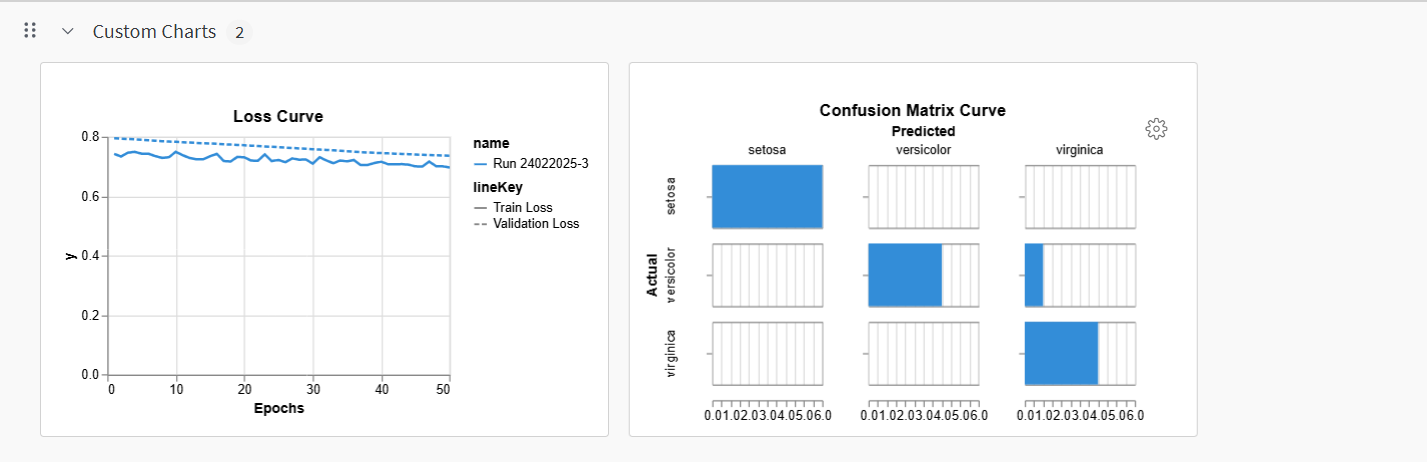

# Part 2


In [ ]:
!pip install autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.common as agco
import itertools
import pandas as pd

** Data Generation

In [ ]:
!rm -rvf models

removed 'models/fallback/models/WeightedEnsemble_L2/model.pkl'
removed directory 'models/fallback/models/WeightedEnsemble_L2'
removed 'models/fallback/models/NeuralNetFastAI/model.pkl'
removed 'models/fallback/models/NeuralNetFastAI/model-internals.pkl'
removed directory 'models/fallback/models/NeuralNetFastAI'
removed 'models/fallback/models/trainer.pkl'
removed directory 'models/fallback/models'
removed 'models/fallback/version.txt'
removed 'models/fallback/predictor.pkl'
removed 'models/fallback/metadata.json'
removed 'models/fallback/learner.pkl'
removed directory 'models/fallback'
removed 'models/auto_mlp_simple_grid/utils/data/y_val.pkl'
removed 'models/auto_mlp_simple_grid/utils/data/X_val.pkl'
removed 'models/auto_mlp_simple_grid/utils/data/y.pkl'
removed 'models/auto_mlp_simple_grid/utils/data/X.pkl'
removed directory 'models/auto_mlp_simple_grid/utils/data'
removed directory 'models/auto_mlp_simple_grid/utils'
removed directory 'models/auto_mlp_simple_grid/models/NeuralNetTor

In [ ]:
from autogluon.core.models import AbstractModel

class PyTorchWrapper(AbstractModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model = None
        self.num_epochs = kwargs.get('num_epochs', 5)
        self.learning_rate = kwargs.get('learning_rate', 1e-3)
        self.batch_size = kwargs.get('batch_size', 2)

    def _fit(self, X, y, **kwargs):
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32)

        # Initialize the model
        self.model = MLP()

        # Define loss and optimizer
        optimiser = AdamW(model.parameters(), lr=self.learning_rate)
        criteria = CrossEntropyLoss()

        # Training loop
        for epoch in range(self.num_epochs):  # Adjust epochs as needed
            optimiser.zero_grad()
            outputs = self.model(X_tensor)
            loss = criteria(outputs, y_tensor)
            loss.backward()
            optimiser.step()

    def _predict(self, X, **kwargs):
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

In [ ]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
target = pd.Series(data['target'], name="target")

targets = column_name=data['feature_names'].copy()
targets.append(['target'])
df = pd.concat([df, target.to_frame()], axis=1)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)

train_data = TabularDataset("train.csv")
test_data = TabularDataset("test.csv")

batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

final_manual = []
ncs_data= []
results_df = None

In [ ]:
# Train model for each combination of hyperparameters
for batch_size, lr, epochs in itertools.product(batch_sizes, learning_rates, epochs_list):

    print(f"\nTraining with Batch Size={batch_size}, Learning Rate={lr}, Epochs={epochs}")

    # Train AutoGluon predictor with manually set hyperparameters
    """Train model with manual hyperparameters."""
    manual_params = {
        'NN_TORCH': {  # NN_TORCH is AutoGluon's neural network model
            'num_epochs': epochs,        # Number of training cycles
            'learning_rate': lr,   # How fast the model learns
            'batch_size': batch_size,        # Number of samples per training step
            'hidden_size': 16,      # Number of neurons in hidden layers
            'num_layers': 1,         # Number of hidden layers
            'activation': 'relu'     # Activation function
        }
    }

    print("\nManual Hyperparameters:")
    for param, value in manual_params['NN_TORCH'].items():
        print(f"{param}: {value}")

    predictor = TabularPredictor(
        label='target',           # Column name of our target variable
        eval_metric='accuracy',   # Metric to optimize
        path='models/manual_mlp',  # Where to save the model
        verbosity = 0,
        log_to_file=True,
        log_file_path="./log"
    )

    print("\nStarting manual training...")
    predictor.fit(
        train_data,
        hyperparameters=manual_params,  # Our manual settings
        time_limit=600,                 # Maximum training time (10 minutes)
        presets='medium_quality_faster_train'
    )

    # Evaluate on test set
    y_true = test_data["target"]
    y_pred = predictor.predict(test_data)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    final_manual.append({"Batch Size": batch_size, "Learning Rate": lr, "Epochs": epochs, "Accuracy": accuracy, "F1 Score": f1})
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    ncs_data.append(cm)

# Convert results to DataFrame and display
results_df = pd.DataFrame(final_manual)


Training with Batch Size=2, Learning Rate=0.001, Epochs=1

Manual Hyperparameters:
num_epochs: 1
learning_rate: 0.001
batch_size: 2
hidden_size: 16
num_layers: 1
activation: relu

Starting manual training...
Accuracy: 0.6000, F1 Score: 0.5156

Training with Batch Size=2, Learning Rate=0.001, Epochs=3

Manual Hyperparameters:
num_epochs: 3
learning_rate: 0.001
batch_size: 2
hidden_size: 16
num_layers: 1
activation: relu

Starting manual training...
Accuracy: 0.6667, F1 Score: 0.5649

Training with Batch Size=2, Learning Rate=0.001, Epochs=5

Manual Hyperparameters:
num_epochs: 5
learning_rate: 0.001
batch_size: 2
hidden_size: 16
num_layers: 1
activation: relu

Starting manual training...
Accuracy: 0.6667, F1 Score: 0.5649

Training with Batch Size=2, Learning Rate=1e-05, Epochs=1

Manual Hyperparameters:
num_epochs: 1
learning_rate: 1e-05
batch_size: 2
hidden_size: 16
num_layers: 1
activation: relu

Starting manual training...
Accuracy: 0.0000, F1 Score: 0.0000

Training with Batch Siz

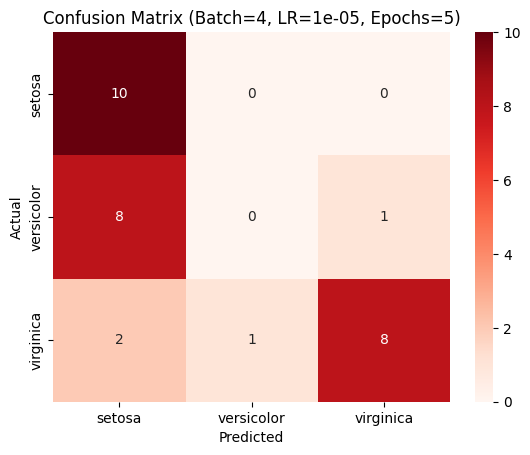

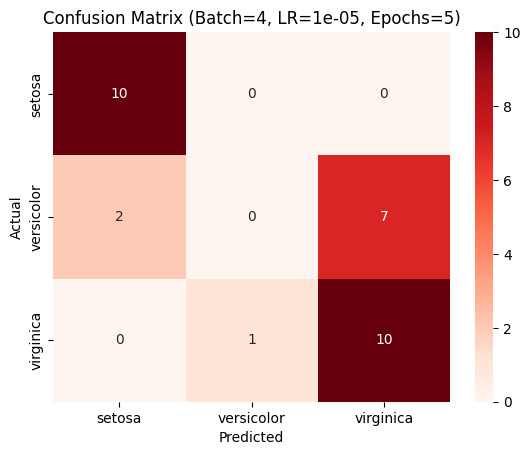

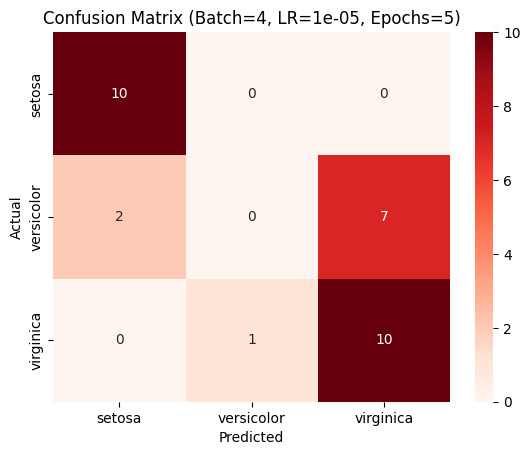

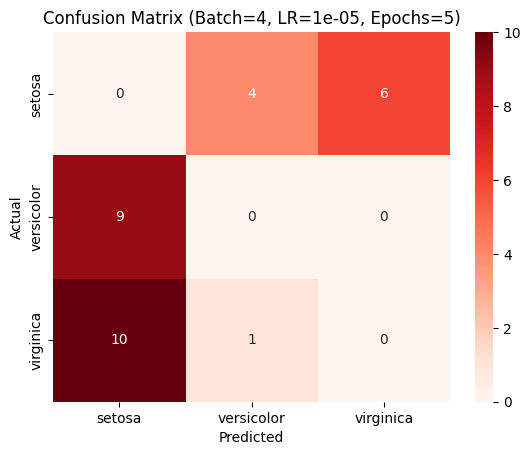

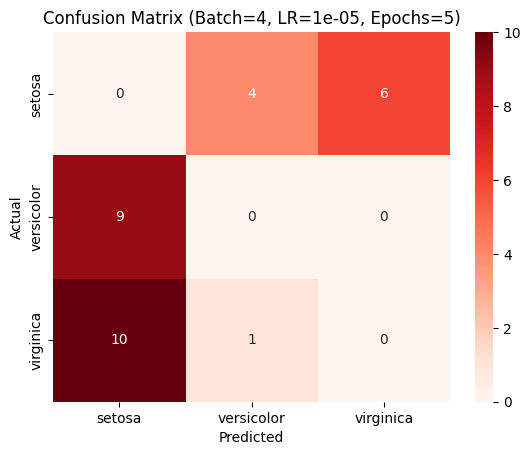

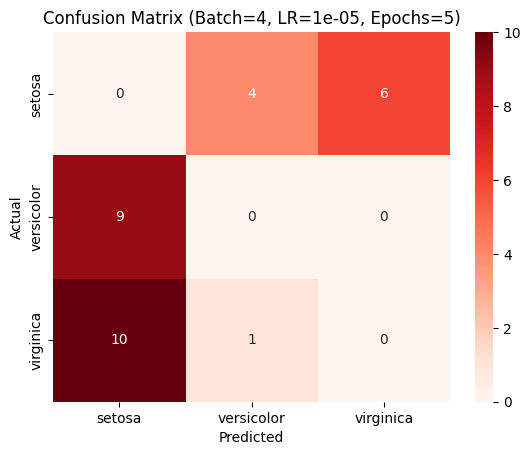

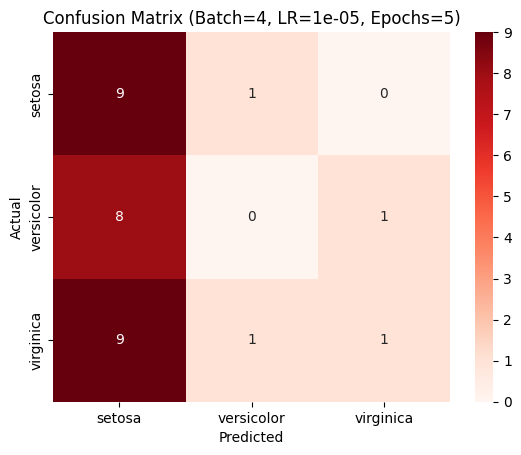

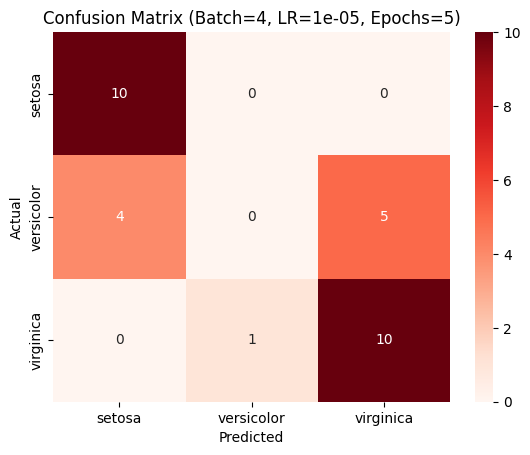

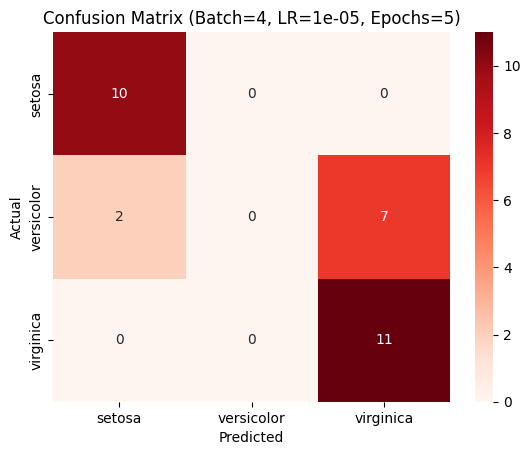

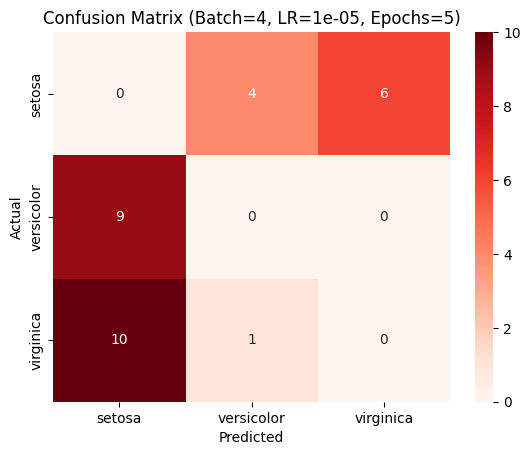

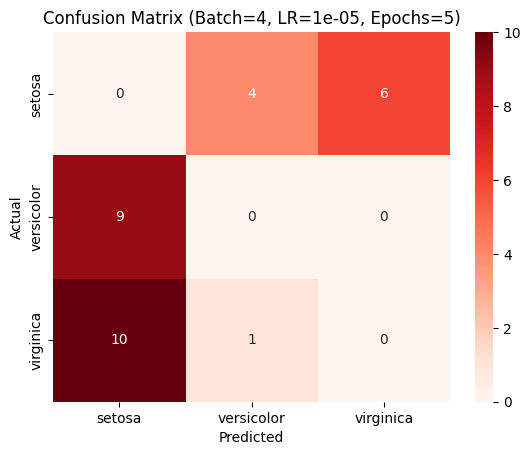

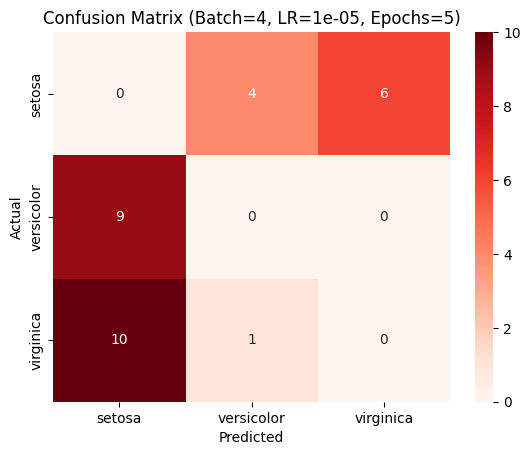

In [ ]:
for cm in ncs_data:
    sn.heatmap(cm, annot=True, cmap="Reds", fmt="d", xticklabels=data['target_names'], yticklabels=data['target_names'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Batch={batch_size}, LR={lr}, Epochs={epochs})")
    plt.show()

In [ ]:
results_df

,Batch Size,Learning Rate,Epochs,Accuracy,F1 Score
0,2,0.00100,1,0.600000,0.515556
1,2,0.00100,3,0.666667,0.564935
2,2,0.00100,5,0.666667,0.564935
3,2,0.00001,1,0.000000,0.000000
4,2,0.00001,3,0.000000,0.000000
5,2,0.00001,5,0.000000,0.000000
6,4,0.00100,1,0.333333,0.223077
7,4,0.00100,3,0.666667,0.559829
8,4,0.00100,5,0.700000,0.581191
9,4,0.00001,1,0.000000,0.000000


## Semi Automated Model Search


### Random

In [ ]:
predictor = TabularPredictor(
    label='target',
    eval_metric='accuracy',
    path='models/auto_mlp_simple_random',
    verbosity=2,
)

hyperparameter_tune_kwargs = {
  'num_trials': 10,
  'scheduler': 'local',
  'searcher': 'random',  # Use random search
}

predictor.fit(
    train_data,
    hyperparameters={'NN_TORCH': {
        'num_epochs': agco.space.Categorical(1,3,5),         # Fixed number of epochs
        'learning_rate': agco.space.Categorical(1e-3,1e-5),   # Fixed learning rate
        'batch_size': agco.space.Categorical(2, 4),
        'activation': 'relu',     # Fixed activation
        'optimizer': 'adam'   ,    # Fixed optimizer
    }},  # Let AutoGluon handle all parameters
    time_limit=600,
    verbosity=2,
    presets='medium_quality_faster_train',
    raise_on_no_models_fitted=True,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)





Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.12 GB / 12.67 GB (71.9%)
Disk Space Avail:   78.40 GB / 112.64 GB (69.6%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/content/models/auto_mlp_simple_random"
Train Data Rows:    120
Train Data Columns: 4
Label Column:       target
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch        |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 10                    |
+--------------------------------------------------------+

View detailed results here: /content/models/auto_mlp_simple_random/models/NeuralNetTorch


2025-02-25 17:17:57,535	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-02-25 17:17:57,550	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/models/auto_mlp_simple_random/models/NeuralNetTorch' in 0.0115s.
2025-02-25 17:17:57,591	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/content/models/auto_mlp_simple_random/models/NeuralNetTorch", trainable=...)
2025-02-25 17:17:57,611	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 10 trial(s):
- 6cd39_00000: FileNotFoundError('Could not fetch metrics for 6cd39_00000: both result.json and progress.csv were not found at /content/models/auto_mlp_simple_random/models/NeuralNetTorch/6cd39_00000')
- 6cd39_00001: FileNotFoundErro

In [ ]:
import autogluon as ag
ag.tabular.models.tabular_nn.hyperparameters.parameters.get_hyper_params(framework='pytorch')

{'activation': 'relu',
 'embedding_size_factor': 1.0,
 'embed_exponent': 0.56,
 'max_embedding_dim': 100,
 'y_range': None,
 'y_range_extend': 0.05,
 'dropout_prob': 0.1,
 'optimizer': 'adam',
 'learning_rate': 0.0003,
 'weight_decay': 1e-06,
 'proc.embed_min_categories': 4,
 'proc.impute_strategy': 'median',
 'proc.max_category_levels': 100,
 'proc.skew_threshold': 0.99,
 'use_ngram_features': False,
 'num_layers': 4,
 'hidden_size': 128,
 'max_batch_size': 512,
 'use_batchnorm': False,
 'loss_function': 'auto'}

In [ ]:
# Predict on test data
y_pred = predictor.predict(test_data)

# Calculate F1-score and accuracy manually
y_true = test_data['target']
f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

if len(predictor.model_names()) > 0:
    df1 = predictor.fit_summary()
else:
    raise RuntimeError("Alternative approach also failed to fit models")

F1-score: 0.932
Accuracy: 0.933
*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch/6cd39_00000      0.875    accuracy       0.006271  5.296325                0.006271           5.296325            1       True          1
1         WeightedEnsemble_L2      0.875    accuracy       0.010323  5.304422                0.004051           0.008097            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 4 | ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Plot summary of models saved to file: /content/models/auto_mlp_simple_randomSummaryOfModels.html
*** End

### Bayes

In [ ]:
predictor = TabularPredictor(
    label='target',
    eval_metric='accuracy',
    path='models/auto_mlp_simple_bayes',
    verbosity=1,
)

hyperparameter_tune_kwargs = {
  'num_trials': 3,
  'scheduler': 'local',
  'searcher': 'bayes',  # Use Bayes search
}

predictor.fit(
    train_data,
    hyperparameters={'NN_TORCH': {
        'num_epochs': agco.space.Categorical(1,3,5),         # Fixed number of epochs
        'learning_rate': agco.space.Categorical(1e-3,1e-5),   # Fixed learning rate
        'batch_size': agco.space.Categorical(2, 4),
        'activation': 'relu',     # Fixed activation
        'optimizer': 'adam'   ,    # Fixed optimizer
    }},  # Let AutoGluon handle all parameters
    time_limit=600,
    verbosity=0,
    presets='medium_quality_faster_train',
    raise_on_no_models_fitted=True,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

# Predict on test data
y_pred = predictor.predict(test_data)

# Calculate F1-score and accuracy manually
y_true = test_data['target']
f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

if len(predictor.model_names()) > 0:
    df1 = predictor.fit_summary()
else:
    raise RuntimeError("Alternative approach also failed to fit models")

+---------------------------------------------------+
| Configuration for experiment     NeuralNetTorch   |
+---------------------------------------------------+
| Search algorithm                 SearchGenerator  |
| Scheduler                        FIFOScheduler    |
| Number of trials                 3                |
+---------------------------------------------------+

View detailed results here: /content/models/auto_mlp_simple_bayes/models/NeuralNetTorch


2025-02-25 17:20:48,684	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/models/auto_mlp_simple_bayes/models/NeuralNetTorch' in 0.0135s.
2025-02-25 17:20:48,696	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 3 trial(s):
- d4b7a783: FileNotFoundError('Could not fetch metrics for d4b7a783: both result.json and progress.csv were not found at /content/models/auto_mlp_simple_bayes/models/NeuralNetTorch/d4b7a783')
- 2bba95a7: FileNotFoundError('Could not fetch metrics for 2bba95a7: both result.json and progress.csv were not found at /content/models/auto_mlp_simple_bayes/models/NeuralNetTorch/2bba95a7')
- 9e919863: FileNotFoundError('Could not fetch metrics for 9e919863: both result.json and progress.csv were not found at /content/models/auto_mlp_simple_bayes/models/NeuralNetTorch/9e919863')



F1-score: 0.932
Accuracy: 0.933
*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch/d4b7a783   0.875000    accuracy       0.005051  10.347493                0.005051          10.347493            1       True          1
1      WeightedEnsemble_L2   0.875000    accuracy       0.006083  10.352267                0.001032           0.004774            2       True          4
2  NeuralNetTorch/9e919863   0.458333    accuracy       0.004616   4.046327                0.004616           4.046327            1       True          3
3  NeuralNetTorch/2bba95a7   0.166667    accuracy       0.007169   4.884039                0.007169           4.884039            1       True          2
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'TabularNeuralNetTorchModel'}
Bagging used: False 
Multi

In [ ]:
predictor.leaderboard()['model']

,model
0,NeuralNetTorch/e7d1b_00003
1,WeightedEnsemble_L2
2,NeuralNetTorch/e7d1b_00004
3,NeuralNetTorch/e7d1b_00000
4,NeuralNetTorch/e7d1b_00002
5,NeuralNetTorch/e7d1b_00001


In [ ]:
import pickle
import os

for model in predictor.leaderboard()['model']:
  f = open(os.path.join(os.getcwd() + '/models/auto_mlp_simple/models', model, "model.pkl"), "rb")
  model_load = pickle.load(f)
  params = model_load._get_model_params()
  print(params)


{'num_epochs': 3, 'epochs_wo_improve': None, 'activation': 'relu', 'embedding_size_factor': 1.1, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001, 'weight_decay': 6.2830384721739395e-06, 'proc.embed_min_categories': 10, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 500, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto', 'batch_size': 4}
{'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}
{'num_epochs': 5, 'epochs_wo_improve': None, 'activation': 'relu', 'embedding_size_factor': 1.2, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.001, 'weight_decay': 5.566763740566817e

## Automaed Search

In [ ]:
predictor = None
df1 = None
df2 = None

try:
    predictor = TabularPredictor(
        label='target',
        eval_metric='accuracy',
        path='models/auto_mlp_simple',
        verbosity=1,
    )

    predictor.fit(
        train_data,
        hyperparameters={'NN_TORCH': {}},  # Let AutoGluon handle all parameters
        time_limit=600,
        verbosity=0,
        included_model_types=['NN_TORCH'],
        presets=['optimize_for_deployment', 'medium_quality'],
        raise_on_no_models_fitted=False
    )

    if len(predictor.model_names()) > 0:
        df1 = predictor.leaderboard()
    else:
        raise RuntimeError("Alternative approach also failed to fit models")

except Exception as e2:
    print(f"\nError during alternative approach: {str(e2)}")

    # Final fallback: Try with all model types
    print("\nTrying final fallback with all model types...")
    predictor = TabularPredictor(
        label='target',
        eval_metric='accuracy',
        path='models/fallback',
        verbosity=1,
    )

    predictor.fit(
        train_data,
        time_limit=600,
        verbosity=0,
        presets=['optimize_for_deployment', 'medium_quality'],
        raise_on_no_models_fitted=False
    )
    df2 = predictor.leaderboard()

In [ ]:
print("\nModel Leaderboard (Auto Approach):")
df1


Model Leaderboard (Auto Approach):


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,1.0,accuracy,0.005324,3.534946,0.005324,3.534946,1,True,1
1,WeightedEnsemble_L2,1.0,accuracy,0.006582,3.541510,0.001258,0.006564,2,True,2


In [ ]:
data = load_iris()
X = data['data']
Y = data['target']
labels = []

for x in range(len(Y)):
    if Y[x] == 0:
        labels.append('setosa')
    elif Y[x] == 1:
        labels.append('versicolor')
    else:
        labels.append('virginica')

X_normed = X / X.max(axis=0)

X_train, X_testing, y_train, y_testing = train_test_split(X_normed, Y, test_size=0.3, random_state=20)
X_validation, X_test, y_validation, y_test = train_test_split(X_testing, y_testing, test_size=0.33, random_state=20)
print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(105, 4) (30, 4) (15, 4) (105,) (30,) (15,)


In [ ]:
training_loss = []
valid_loss = []

In [ ]:
!rm -rvf model_grid_search
!mkdir model_grid_search

removed 'model_grid_search/config_lr5_epoch1_batch2.json'
removed 'model_grid_search/config_lr3_epoch5_batch4.json'
removed 'model_grid_search/config_lr5_epoch5_batch2.json'
removed 'model_grid_search/config_lr5_epoch1_batch4.json'
removed 'model_grid_search/config_lr5_epoch5_batch4.json'
removed 'model_grid_search/config_lr3_epoch1_batch2.json'
removed 'model_grid_search/config_lr3_epoch3_batch4.json'
removed 'model_grid_search/config_lr5_epoch3_batch2.json'
removed 'model_grid_search/config_lr3_epoch1_batch4.json'
removed 'model_grid_search/config_lr3_epoch5_batch2.json'
removed 'model_grid_search/config_lr5_epoch3_batch4.json'
removed 'model_grid_search/config_lr3_epoch3_batch2.json'
removed directory 'model_grid_search'


In [24]:
from ray import train
import json
from os.path import join
import os
from math import ceil

def train_MLP(config):

  device = "cuda" if torch.cuda.is_available() else "cpu"

  lr = config['lr']
  num_epochs = ceil(config['num_epochs'])
  batch_size = ceil(config['batch_size'])

  model = MLP().to(device)
  optimiser = AdamW(model.parameters(), lr=lr)
  criteria = CrossEntropyLoss()

  X_train_model = tensor(X_train, dtype=torch.float32)
  y_train_model = tensor(y_train)

  train_dataset = TensorDataset(X_train_model, y_train_model)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = TensorDataset(tensor(X_validation, dtype=torch.float32), tensor(y_validation))
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TensorDataset(tensor(X_test, dtype=torch.float32), tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  training_loss = []
  valid_loss = []

  for epoch in range(num_epochs):
    print("Epoch",  epoch)
    running_loss = 0.0
    val_loss = 0.0
    model.train()

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criteria(outputs, Y_batch)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)

    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.item()
      avg_val_loss = val_loss / len(val_loader)
      valid_loss.append(avg_val_loss)

  model.eval()

  pred = []
  label = []
  with torch.no_grad():
      for inputs, labels in test_loader:
          for x in labels:
            label.append(x)
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          # Update the test accuracy
          _, preds = torch.max(outputs, 1)
          for x in preds.cpu().numpy():
            pred.append(x)

  accuracy = accuracy_score(pred, label)
  print(accuracy)
  f1 = f1_score(pred, label, average="weighted")
  print(f1)

  print("Acc: ", accuracy, "\nF1:", f1)
  file_name = join("/content/model_grid_search",f"config_lr{3 if(lr == 1e-3) else 5}_epoch{num_epochs}_batch{batch_size}.json")
  f = open(file_name, "w")
  json.dump({"accuracy": accuracy, "f1": f1, "tl": training_loss, "vl": valid_loss }, f)
  f.close()
  train.report({"accuracy": accuracy, "f1": f1})


In [ ]:
def accuracy_score(y_true, y_pred):
    print(y_true, y_pred)
    correct = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
    return correct / len(y_true) if y_true else 0.0

In [ ]:
def f1_score(y_true, y_pred):
    print(y_true, y_pred)
    tp = sum(y_t == 1 and y_p == 1 for y_t, y_p in zip(y_true, y_pred))
    fp = sum(y_t == 0 and y_p == 1 for y_t, y_p in zip(y_true, y_pred))
    fn = sum(y_t == 1 and y_p == 0 for y_t, y_p in zip(y_true, y_pred))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return f1

In [ ]:
import ray
from ray import tune

search_space = {
    "lr": tune.grid_search([1e-3, 1e-5]),
    "num_epochs": tune.grid_search([1,3,5]),
    "batch_size": tune.grid_search([2, 4])
}

ray.shutdown()
tuner = tune.Tuner(
    tune.with_resources(train_MLP, {"cpu": 1}),
    param_space=search_space,
)

ray.init(ignore_reinit_error=True)
results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
print("Best Config:", best_result.config)
ray.shutdown()

2025-02-26 13:21:55,638	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


+------------------------------------------------------------------+
| Configuration for experiment     train_MLP_2025-02-26_13-21-53   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 12                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_MLP_2025-02-26_13-21-53
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_13-21-53_960328_10583/artifacts/2025-02-26_13-22-25/train_MLP_2025-02-26_13-21-53/driver_artifacts`

Trial status: 12 PENDING
Current time: 2025-02-26 13:22:26. Total running time: 0s
Logical resource usage: 0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+-----------------------------------------------------------------

(train_MLP pid=19527) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(train_MLP pid=19527)   return self._call_impl(*args, **kwargs)



Trial train_MLP_b82a5_00003 completed after 1 iterations at 2025-02-26 13:22:50. Total running time: 24s
+------------------------------------------------+
| Trial train_MLP_b82a5_00003 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       4.80002 |
| time_total_s                           4.80002 |
| training_iteration                           1 |
| accuracy                                   0.4 |
| f1                                     0.57143 |
+------------------------------------------------+
(train_MLP pid=19527) 0.4
(train_MLP pid=19527) 0.5714285714285714
(train_MLP pid=19527) Acc:  0.4 
(train_MLP pid=19527) F1: 0.5714285714285714
(train_MLP pid=19531) 0.26666666666666666
(train_MLP pid=19531) 0.4210526315789474
(train_MLP pid=19531) F1: 0.4210526315789474

Trial train_MLP_b82a5_00001 completed after 1 iterations at 2025-02-26 13:22:50. Total running time: 24s
+----

2025-02-26 13:22:52,319	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_MLP_2025-02-26_13-21-53' in 0.0743s.



Trial train_MLP_b82a5_00010 completed after 1 iterations at 2025-02-26 13:22:52. Total running time: 25s
+------------------------------------------------+
| Trial train_MLP_b82a5_00010 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       5.62792 |
| time_total_s                           5.62792 |
| training_iteration                           1 |
| accuracy                               0.26667 |
| f1                                     0.42105 |
+------------------------------------------------+
(train_MLP pid=19533) 0.26666666666666666
(train_MLP pid=19533) 0.4210526315789474
(train_MLP pid=19533) F1: 0.4210526315789474

Trial status: 12 TERMINATED
Current time: 2025-02-26 13:22:52. Total running time: 25s
Logical resource usage: 1.0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+--------------------------------------------------------------------------

(train_MLP pid=19539) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 11x across cluster]
(train_MLP pid=19539)   return self._call_impl(*args, **kwargs) [repeated 11x across cluster]


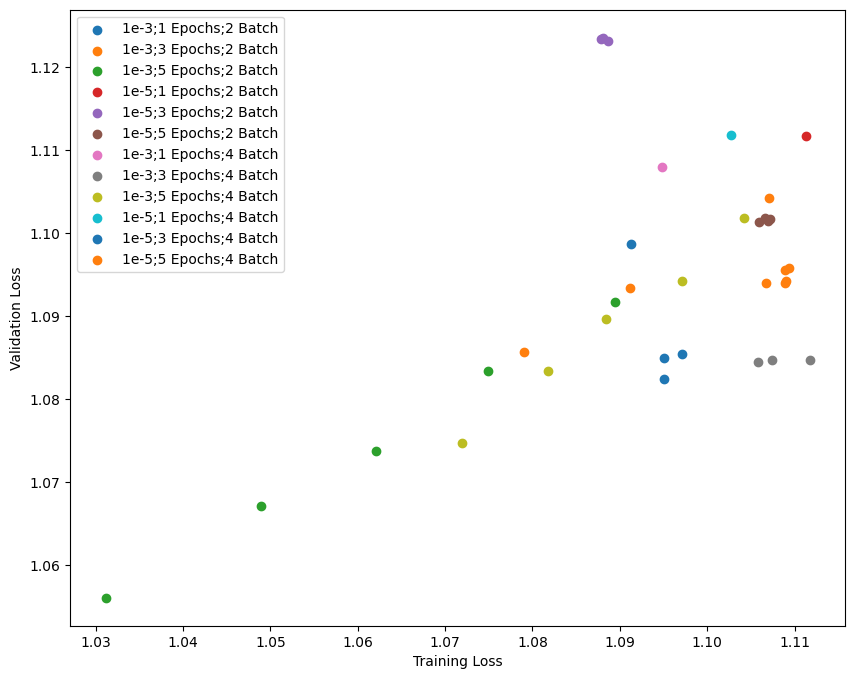

In [ ]:
import matplotlib.pyplot as plt
import itertools

lr = [3, 5]
epoch = [1,3,5]
batch = [2, 4]

data = []
legend = []

plt.figure(figsize=(10, 8))

for batch_size, lr_, epochs in itertools.product(batch, lr, epoch):
  f = open(f"/content/model_grid_search/config_lr{lr_}_epoch{epochs}_batch{batch_size}.json")
  j = json.load(f)
  data.append(j)
  plt.scatter(j['tl'], j['vl'], label=f"1e-{lr_};{epochs} Epochs;{batch_size} Batch")

  legend.append(f"1e-{lr_};{epochs} Epochs;{batch_size} Batch")
  f.close()
plt.ylabel("Validation Loss")
plt.xlabel("Training Loss")
plt.legend()
plt.show()




### Epoch Relation

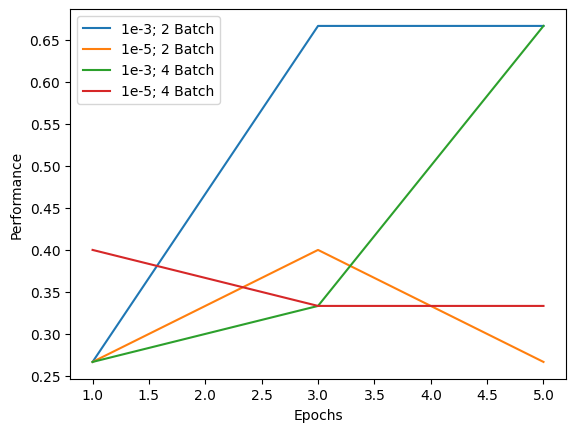

In [ ]:
plt.figure()
legend = []

for batch_size, lr_ in itertools.product(batch, lr):
  data = []
  for epochs in epoch:
    f = open(f"/content/model_grid_search/config_lr{lr_}_epoch{epochs}_batch{batch_size}.json")
    j = json.load(f)
    data.append(j['accuracy'])
    f.close()
  plt.plot(epoch, data, label=f"1e-{lr_}; {batch_size} Batch")

plt.ylabel("Performance")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Learning Rate Relation

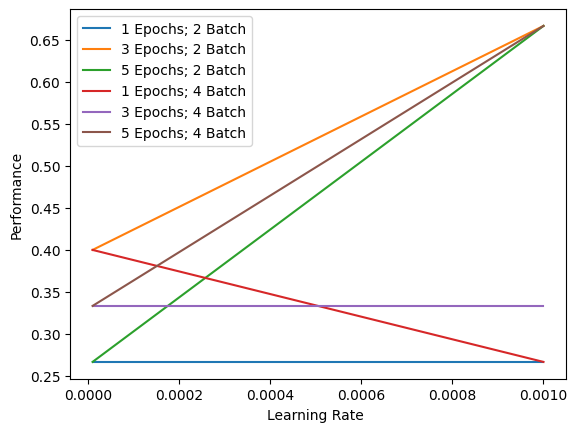

In [ ]:
plt.figure()
for batch_size, epochs in itertools.product(batch, epoch):
  data = []
  lrr = []
  for lr_ in lr:
    f = open(f"/content/model_grid_search/config_lr{lr_}_epoch{epochs}_batch{batch_size}.json")
    j = json.load(f)
    data.append(j['accuracy'])
    lrr.append(10**-(lr_))
    f.close()
  plt.plot(lrr, data, label=f"{epochs} Epochs; {batch_size} Batch")

plt.ylabel("Performance")
plt.xlabel("Learning Rate ")
plt.legend()
plt.show()

### Batch Size


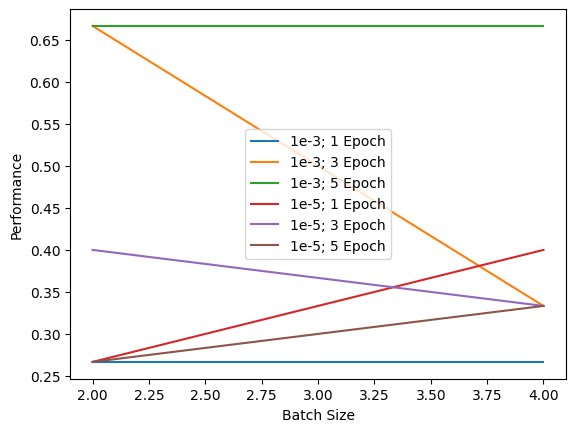

In [ ]:
plt.figure()
for lr_, epochs in itertools.product(lr, epoch):
  data = []
  for batch_size in batch:
    f = open(f"/content/model_grid_search/config_lr{lr_}_epoch{epochs}_batch{batch_size}.json")
    j = json.load(f)
    data.append(j['accuracy'])
    f.close()
  plt.plot(batch, data, label=f"1e-{lr_}; {epochs} Epoch")

plt.ylabel("Performance")
plt.xlabel("Batch Size")
plt.legend()
plt.show()

## Random

In [ ]:
import ray
from ray import tune
from ray.tune.search.basic_variant import BasicVariantGenerator

search_space = {
    "lr": tune.choice([1e-3, 1e-5]),
    "num_epochs": tune.choice([1,3,5]),
    "batch_size": tune.choice([2, 4])
}

ray.shutdown()
tuner = tune.Tuner(
    tune.with_resources(train_MLP, {"cpu": 1}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
      search_alg=BasicVariantGenerator(),  # Uses random search
      num_samples=10  # Runs 10 different trials
  )
)

ray.init(ignore_reinit_error=True)
results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
print("Best Config:", best_result.config)
ray.shutdown()



2025-02-26 13:11:04,005	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2025-02-26 13:11:05,104	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


+------------------------------------------------------------------+
| Configuration for experiment     train_MLP_2025-02-26_13-11-02   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 10                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_MLP_2025-02-26_13-11-02
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_13-11-02_700407_6236/artifacts/2025-02-26_13-11-06/train_MLP_2025-02-26_13-11-02/driver_artifacts`

Trial status: 10 PENDING
Current time: 2025-02-26 13:11:06. Total running time: 0s
Logical resource usage: 0/4 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+-------------------------------------------------------------------

(train_MLP pid=11257) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(train_MLP pid=11257)   return self._call_impl(*args, **kwargs)



Trial train_MLP_21169_00002 completed after 1 iterations at 2025-02-26 13:11:11. Total running time: 5s
+------------------------------------------------+
| Trial train_MLP_21169_00002 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.21297 |
| time_total_s                           1.21297 |
| training_iteration                           1 |
| accuracy                               0.66667 |
| f1                                     0.78632 |
+------------------------------------------------+
(train_MLP pid=11257) 0.6666666666666666
(train_MLP pid=11257) 0.7863247863247864
(train_MLP pid=11257) F1: 0.7863247863247864

Trial train_MLP_21169_00001 completed after 1 iterations at 2025-02-26 13:11:11. Total running time: 5s
+------------------------------------------------+
| Trial train_MLP_21169_00001 result             |
+------------------------------------------------+


(train_MLP pid=11958) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=11958)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]


(train_MLP pid=11958) Epoch 0 [repeated 16x across cluster]
(train_MLP pid=11258) Acc:  0.26666666666666666  [repeated 3x across cluster]

Trial train_MLP_21169_00004 completed after 1 iterations at 2025-02-26 13:11:17. Total running time: 11s
+------------------------------------------------+
| Trial train_MLP_21169_00004 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.03375 |
| time_total_s                           1.03375 |
| training_iteration                           1 |
| accuracy                               0.73333 |
| f1                                     0.82857 |
+------------------------------------------------+

Trial train_MLP_21169_00005 completed after 1 iterations at 2025-02-26 13:11:17. Total running time: 11s
+------------------------------------------------+
| Trial train_MLP_21169_00005 result             |
+-------------------------------------

(train_MLP pid=12464) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=12464)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]


(train_MLP pid=12464) Epoch 0 [repeated 10x across cluster]
(train_MLP pid=11933) Acc:  0.26666666666666666  [repeated 4x across cluster]

Trial train_MLP_21169_00008 completed after 1 iterations at 2025-02-26 13:11:23. Total running time: 17s
+------------------------------------------------+
| Trial train_MLP_21169_00008 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.00531 |
| time_total_s                           1.00531 |
| training_iteration                           1 |
| accuracy                               0.33333 |
| f1                                     0.43333 |
+------------------------------------------------+


2025-02-26 13:11:23,468	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_MLP_2025-02-26_13-11-02' in 0.0088s.


(train_MLP pid=12464) 0.3333333333333333
(train_MLP pid=12464) 0.43333333333333335
(train_MLP pid=12464) F1: 0.43333333333333335

Trial train_MLP_21169_00009 completed after 1 iterations at 2025-02-26 13:11:23. Total running time: 17s
+------------------------------------------------+
| Trial train_MLP_21169_00009 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.10407 |
| time_total_s                           1.10407 |
| training_iteration                           1 |
| accuracy                               0.26667 |
| f1                                     0.41481 |
+------------------------------------------------+

Trial status: 10 TERMINATED
Current time: 2025-02-26 13:11:23. Total running time: 17s
Logical resource usage: 1.0/4 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+--------------------------------------------------------------------------

(train_MLP pid=12489) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(train_MLP pid=12489)   return self._call_impl(*args, **kwargs)


In [ ]:
from ray.tune.schedulers import HyperBandScheduler
import ray
from ray import tune

scheduler = HyperBandScheduler(
    metric="accuracy", mode="max"
)

tuner = tune.Tuner(
    train_MLP,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=20,  # Number of trials
        scheduler=scheduler  # Use Hyperband
    )
)

ray.init(ignore_reinit_error=True)
results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
print("Best Config:", best_result.config)
ray.shutdown()


2025-02-26 13:11:31,912	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2025-02-26 13:11:31,989	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


+------------------------------------------------------------------+
| Configuration for experiment     train_MLP_2025-02-26_13-11-30   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        HyperBandScheduler              |
| Number of trials                 20                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_MLP_2025-02-26_13-11-30
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_13-11-30_427525_6236/artifacts/2025-02-26_13-11-33/train_MLP_2025-02-26_13-11-30/driver_artifacts`

Trial status: 20 PENDING
Current time: 2025-02-26 13:11:33. Total running time: 0s
Logical resource usage: 4.0/4 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+-----------------------------------------------------------------

(train_MLP pid=13474) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(train_MLP pid=13474)   return self._call_impl(*args, **kwargs)



Trial train_MLP_333f5_00003 completed after 1 iterations at 2025-02-26 13:11:38. Total running time: 5s
+------------------------------------------------+
| Trial train_MLP_333f5_00003 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.11868 |
| time_total_s                           1.11868 |
| training_iteration                           1 |
| accuracy                               0.66667 |
| f1                                     0.76923 |
+------------------------------------------------+

Trial train_MLP_333f5_00001 completed after 1 iterations at 2025-02-26 13:11:38. Total running time: 5s
+------------------------------------------------+
| Trial train_MLP_333f5_00001 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.12037 |
| time_total_s           

(train_MLP pid=14180) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=14180)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]


(train_MLP pid=14180) Epoch 2 [repeated 16x across cluster]
(train_MLP pid=13473) Acc:  0.26666666666666666  [repeated 3x across cluster]

Trial train_MLP_333f5_00005 completed after 1 iterations at 2025-02-26 13:11:45. Total running time: 12s
+------------------------------------------------+
| Trial train_MLP_333f5_00005 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.00337 |
| time_total_s                           1.00337 |
| training_iteration                           1 |
| accuracy                                   0.4 |
| f1                                     0.57143 |
+------------------------------------------------+
(train_MLP pid=14180) 0.4
(train_MLP pid=14180) 0.5714285714285714
(train_MLP pid=14180) F1: 0.5714285714285714

Trial train_MLP_333f5_00006 completed after 1 iterations at 2025-02-26 13:11:45. Total running time: 12s
+---------------------------

(train_MLP pid=14627) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=14627)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]



Trial train_MLP_333f5_00008 completed after 1 iterations at 2025-02-26 13:11:51. Total running time: 18s
+------------------------------------------------+
| Trial train_MLP_333f5_00008 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.31153 |
| time_total_s                           1.31153 |
| training_iteration                           1 |
| accuracy                                   0.4 |
| f1                                     0.57143 |
+------------------------------------------------+
(train_MLP pid=14627) 0.4
(train_MLP pid=14627) 0.5714285714285714
(train_MLP pid=14627) F1: 0.5714285714285714

Trial train_MLP_333f5_00009 started with configuration:
+----------------------------------------------+
| Trial train_MLP_333f5_00009 config           |
+----------------------------------------------+
| batch_size                                 2 |
| lr               

(train_MLP pid=15234) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=15234)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]


(train_MLP pid=15234) Epoch 1 [repeated 17x across cluster]
(train_MLP pid=14761) Acc:  0.3333333333333333  [repeated 4x across cluster]

Trial train_MLP_333f5_00014 started with configuration:
+----------------------------------------------+
| Trial train_MLP_333f5_00014 config           |
+----------------------------------------------+
| batch_size                                 4 |
| lr                                     1e-05 |
| num_epochs                                 1 |
+----------------------------------------------+

Trial train_MLP_333f5_00013 started with configuration:
+----------------------------------------------+
| Trial train_MLP_333f5_00013 config           |
+----------------------------------------------+
| batch_size                                 2 |
| lr                                     1e-05 |
| num_epochs                                 5 |
+----------------------------------------------+

Trial train_MLP_333f5_00012 completed after 1 iterations at 20

(train_MLP pid=15851) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 4x across cluster]
(train_MLP pid=15851)   return self._call_impl(*args, **kwargs) [repeated 4x across cluster]


(train_MLP pid=15851) 0.3333333333333333
(train_MLP pid=15851) 0.5
(train_MLP pid=15851) F1: 0.5

Trial train_MLP_333f5_00016 completed after 1 iterations at 2025-02-26 13:12:04. Total running time: 31s
+------------------------------------------------+
| Trial train_MLP_333f5_00016 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.17069 |
| time_total_s                           1.17069 |
| training_iteration                           1 |
| accuracy                               0.33333 |
| f1                                         0.5 |
+------------------------------------------------+

Trial train_MLP_333f5_00018 started with configuration:
+----------------------------------------------+
| Trial train_MLP_333f5_00018 config           |
+----------------------------------------------+
| batch_size                                 2 |
| lr                              

2025-02-26 13:12:06,616	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_MLP_2025-02-26_13-11-30' in 0.0100s.



Trial train_MLP_333f5_00019 completed after 1 iterations at 2025-02-26 13:12:06. Total running time: 33s
+------------------------------------------------+
| Trial train_MLP_333f5_00019 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       1.18111 |
| time_total_s                           1.18111 |
| training_iteration                           1 |
| accuracy                               0.73333 |
| f1                                     0.82857 |
+------------------------------------------------+

Trial status: 20 TERMINATED
Current time: 2025-02-26 13:12:06. Total running time: 33s
Logical resource usage: 1.0/4 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status          lr     num_epochs     batch_size 

(train_MLP pid=16034) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 3x across cluster]
(train_MLP pid=16034)   return self._call_impl(*args, **kwargs) [repeated 3x across cluster]


### Basyean

In [ ]:
!pip install bayesian-optimization==1.4.3

In [27]:
from ray.tune.search.bayesopt import BayesOptSearch
import ray
from ray import tune

bayesopt = BayesOptSearch(metric="accuracy", mode="max")

search_space = {
    "lr": tune.loguniform(1e-3, 1e-5),
    "num_epochs": tune.uniform(1,5),
    "batch_size": tune.uniform(2, 4)
}

tuner = tune.Tuner(
    train_MLP,
    tune_config=tune.TuneConfig(
        search_alg=bayesopt,
          num_samples=5,  # Number of trials
    ),
    param_space=search_space,
)
results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
print("Best Config:", best_result.config)
ray.shutdown()

2025-02-26 13:51:12,095	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


+------------------------------------------------------------------+
| Configuration for experiment     train_MLP_2025-02-26_13-51-12   |
+------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                 |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 5                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_MLP_2025-02-26_13-51-12
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_13-32-57_643767_21584/artifacts/2025-02-26_13-51-12/train_MLP_2025-02-26_13-51-12/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-02-26 13:51:12. Total running time: 0s
Logical resource usage: 1.0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+----------------------------------------------------------------

(train_MLP pid=56549) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(train_MLP pid=56549)   return self._call_impl(*args, **kwargs)



Trial train_MLP_571a3499 started with configuration:
+---------------------------------------------+
| Trial train_MLP_571a3499 config             |
+---------------------------------------------+
| batch_size                          3.19732 |
| lr                                  0.00085 |
| num_epochs                          1.62398 |
+---------------------------------------------+

Trial train_MLP_571a3499 completed after 1 iterations at 2025-02-26 13:51:21. Total running time: 9s
+---------------------------------------------+
| Trial train_MLP_571a3499 result             |
+---------------------------------------------+
| checkpoint_dir_name                         |
| time_this_iter_s                     1.0377 |
| time_total_s                         1.0377 |
| training_iteration                        1 |
| accuracy                            0.53333 |
| f1                                  0.63626 |
+---------------------------------------------+
(train_MLP pid=56652) 0.5333

(train_MLP pid=56755) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 2x across cluster]
(train_MLP pid=56755)   return self._call_impl(*args, **kwargs) [repeated 2x across cluster]


(train_MLP pid=56755) Epoch 0 [repeated 3x across cluster]
(train_MLP pid=56652) Acc:  0.5333333333333333 

Trial train_MLP_18973f21 completed after 1 iterations at 2025-02-26 13:51:25. Total running time: 13s
+---------------------------------------------+
| Trial train_MLP_18973f21 result             |
+---------------------------------------------+
| checkpoint_dir_name                         |
| time_this_iter_s                    1.19837 |
| time_total_s                        1.19837 |
| training_iteration                        1 |
| accuracy                            0.26667 |
| f1                                  0.42105 |
+---------------------------------------------+
(train_MLP pid=56755) 0.26666666666666666
(train_MLP pid=56755) 0.4210526315789474
(train_MLP pid=56755) Acc:  0.26666666666666666 
(train_MLP pid=56755) F1: 0.4210526315789474

Trial train_MLP_494594e3 started with configuration:
+---------------------------------------------+
| Trial train_MLP_494594e3 conf

2025-02-26 13:51:33,244	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_MLP_2025-02-26_13-51-12' in 0.0060s.



Trial train_MLP_505568a9 completed after 1 iterations at 2025-02-26 13:51:33. Total running time: 21s
+---------------------------------------------+
| Trial train_MLP_505568a9 result             |
+---------------------------------------------+
| checkpoint_dir_name                         |
| time_this_iter_s                    0.99763 |
| time_total_s                        0.99763 |
| training_iteration                        1 |
| accuracy                            0.66667 |
| f1                                  0.78632 |
+---------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2025-02-26 13:51:33. Total running time: 21s
Logical resource usage: 1.0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name           status                lr     num_epochs     batch_size     iter     total time (s)

(train_MLP pid=56961) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument. [repeated 2x across cluster]
(train_MLP pid=56961)   return self._call_impl(*args, **kwargs) [repeated 2x across cluster]


In [31]:
basiean = {'lr': 0.0007897842804285067, 'num_epochs': 2, 'batch_size': 4, 'acc': 0.666667, 'f1': 0.786325 }
hyperband = {'lr': 1e-05, 'num_epochs': 5, 'batch_size': 2, 'acc': 0.733333, 'f1': 0.828571 }
random = {'lr': 0.001, 'num_epochs': 3, 'batch_size': 2, 'acc': 0.733333, 'f1': 0.828571 }
grid = {'lr': 0.001, 'num_epochs': 3, 'batch_size': 2, 'acc': 0.733333, 'f1': 0.828571 }

import pandas as pd
df = pd.DataFrame([basiean, hyperband, random, grid], index=['Bayesian', 'Hyperband', 'Random', 'Grid'])
df

,lr,num_epochs,batch_size,acc,f1
Bayesian,0.00079,2,4,0.666667,0.786325
Hyperband,0.00001,5,2,0.733333,0.828571
Random,0.00100,3,2,0.733333,0.828571
Grid,0.00100,3,2,0.733333,0.828571


## **Hyperparameter Tuning Results**

### **Comparison of Different Tuning Methods**

| Method     | Learning Rate | Num Epochs | Batch Size | Accuracy | F1 Score |
|------------|--------------|------------|------------|----------|----------|
| **Bayesian**   | 0.00079      | 2          | 4          | 0.666667 | 0.786325 |
| **Hyperband**  | 0.00001      | 5          | 2          | 0.733333 | 0.828571 |
| **Random**     | 0.00100      | 3          | 2          | 0.733333 | 0.828571 |
| **Grid**       | 0.00100      | 3          | 2          | 0.733333 | 0.828571 |

### **Best Approach: Hyperband**  
1. **Highest Performance:** Matches the best accuracy (0.7333) and F1-score (0.8286).  
2. **Efficient Computation:** Uses adaptive stopping to eliminate weak configurations early.  
3. **Exploration vs. Exploitation:** Strikes a good balance between trying new hyperparameters and optimizing the best ones.  
4. **More Training:** Runs for 5 epochs, longer than Bayesian (2 epochs), improving model performance.  